In [1]:
!pip install pandas-profiling
!pip install seaborn

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures    # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score    # function to calculate mean squared error 

# Privacy-preserving occupancy counting with Linear Regression
March 2022
## Introduction
Previously I have worked on [TinyML as-a-Service](https://ieeexplore.ieee.org/document/9427352) project, *running Machine Learing (ML) inferences on microcontrollers in tiny IoT sensors*, which unlock the power of ML without Cloud computing. I have been looking for a TinyML killer usecase in real life. One of such usecases may be a **privacy-preserving occupancy count device**. Although occupancy counting itself can be done with camera devices, it uploads enomous amount of raw data of recordings on Cloud. Then, those data is proccessed heavily by ML on Cloud GPU. Basically We don't want to expose our privacy data out of our premises. Uploading onto Cloud always has a risk of leaking such data, compared with local processing within sensor devices. Uploading also comes with communication cost, for example, via 5G cellular. My proposal is to enable "people counting in a room with a IoT sensor". ML inference on IoT deivce processes primitive raw data (ex: CO2 emission) locally to detect number of people in a room. People emits CO2. The potential customers of this device may be building maintenance companies (i.e. smart building).They could:

1.   maximize room usage rate by allocating suitable spaces for group of people
2.  reduce energy consumption by controlling lights bulbs and air conditioners for group of people

In shared sauna (yes, here's Finland), for example, the current space availability could be checked online before you go naked. In sauna, people are naked and they can talk about thier secrets in relaxed mood. So privacy matters a lot and we don't want any real sensors installed at all. Probably measuring CO2 emission is acceptable in most of the places. This IoT sensor could be also used to check if your eldery parents are still breathing in your home town. This TinyML device may have bluetooth or Wi-fi connection to send only a single 1 byte of data(number of people, 0-256) occassionally, compared with Giga byte of recording data. This pre-processed information (number of people) doesn't include privacy and uploading cost is cheap.
## Problem Formulation
<!---
* Formalise the application an ML problem.  
* Clearly explain the data points, features and labels of this ML problem
* Explain the source of the dataset
--->
CO2 sensor in a room measures how much CO2 in a room as time passes. ML would detect number of people in a room with amount of CO2. Here's a [Kaggle dataset](https://www.kaggle.com/ananthr1/room-occupancy-estimation-data-set). This dataset is composed of several sensor data. They are CO2, lights on/off, temperature, motion detector and sound. The datapoint is considered **state of a room** at certain time. I picked up **amount of CO2 emission** as a main feature. The rest of sensor data could be used too to complement if CO2 is not enough. The label is **number of people** in a room. The fewer sensors used, the better for TinyML because of the limited computational resources on microcontrollers. We will evaluate the different number of feature set. How to shrink ML model in microcontroller is out of this course scope.

## Method
We will discuss Datapoints, Feature selection, Model, Loss function and Validation below.

### Datapoints
<!---State the number of datapoints, briefly describe the dataset and/or any data preprocessing needed--->
The size of a room is 6m x 4.6m. The number of datapoints is 10,129 without any missing values. 7 sensor nodes transmit almost every 30s via wireless transceivers. Each attribute of sensors:
- Date: YYYY/MM/DD
- Time: HH:MM:SS
- Temperature: In degree Celsius (S1_Temp, S2_Temp, S3_Temp)
- Light: In Lux (S1_Light, S2_Light, S3_Light, S4_Light)
- Sound: In Volts (amplifier output read by ADC) (S1_Sound, S2_Sound, S3_Sound, S4_Sound)
- CO2: In PPM (S5_CO2)
- CO2 Slope: Slope of CO2 values taken in a sliding window (S5_CO2_Slope)
- PIR: Binary value conveying motion detection (S6_PIR, S7_PIR)
- RoomOccupancyCount: Ground Truth (Room_Occupancy_Count)

In [19]:
df = pd.read_csv('https://raw.githubusercontent.com/doyu/people_count_in_room/main/Occupancy_Estimation.csv')

In [20]:
df.iloc[:,:10].head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40


In [24]:
df.rename(columns={'Room_Occupancy_Count':'Target'}).iloc[:,10:].head()
#df.iloc[:,10:].head()

,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Target
0,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [5]:
#df.info()

In [6]:
#profile = ProfileReport(df)
#profile
#profile.to_file("Analysis.html")

### Feature selection
As seen below, all of 3 temperature sensors are correlated so that only _S1_Temp_, which is most correlated to _target_, was chosen.  All of 3 light sensors are correlated so that only _S1_Light_, which is most correlated to _target_, was chosen. All of sound sensors are dropped here because of privacy reason. We started with S1_Temp, S1_Light, S5_CO2, S5_CO2_Slope, S6_PIR, and S7_PIR.

In [7]:
#df.corr()

<AxesSubplot:>

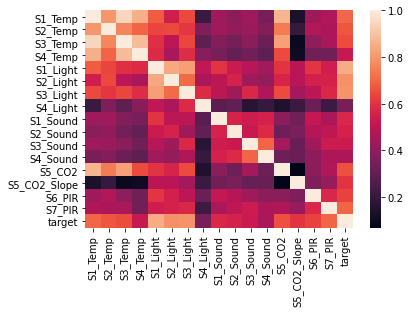

In [8]:
sns.heatmap(df.rename(columns={'Room_Occupancy_Count':'target'}).corr())

In [9]:
#df.columns
df = df[['S1_Temp', 'S1_Light', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count']]
df.head()

,S1_Temp,S1_Light,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,121,390,0.769231,0,0,1
1,24.94,121,390,0.646154,0,0,1
2,25.00,121,390,0.519231,0,0,1
3,25.00,121,390,0.388462,0,0,1
4,25.00,121,390,0.253846,0,0,1


We split feature set into 6 groups X6, X5, X4, X3, X2 and X1. The number shows how many features are included in those X feature set. Each group includes:

In [10]:
X6 = df[['S1_Temp', 'S1_Light', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']]
X5 = df[['S1_Temp', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']]
X4 = df[['S1_Temp', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR']]
X3 = df[['S5_CO2', 'S5_CO2_Slope', 'S6_PIR']]
X2 = df[['S5_CO2', 'S5_CO2_Slope']]
X1 = df[['S5_CO2']]

for i, x in enumerate([X6, X5, X4, X3, X2, X1]):
    features = ", ".join(x.columns)
    print(f"X{6-i}: {features}")

X6: S1_Temp, S1_Light, S5_CO2, S5_CO2_Slope, S6_PIR, S7_PIR
X5: S1_Temp, S5_CO2, S5_CO2_Slope, S6_PIR, S7_PIR
X4: S1_Temp, S5_CO2, S5_CO2_Slope, S6_PIR
X3: S5_CO2, S5_CO2_Slope, S6_PIR
X2: S5_CO2, S5_CO2_Slope
X1: S5_CO2


### Model
<!---Describe and explain (why?) your choice of ML model(s)/hypothesis space(s)*,
e.g., linear predictors, etc-->
We applied linear regression to detect the number of people in a room from various sensor data. It is because the above correlation map showed apparent correlation between features and target. Also linear regression is relatively lighter computation than other method like deep neural network. This is good for TinyML. We run linear regression over different polynomial degree from 1 to 6 against different feature set, X1 to X6. Then, we picked up the best polynomial degree for each feature set and compared their accuracy. 30 patterns of 6 dataset groups with 5 polynomial dgrees are investigated here.

In [11]:
#%%timeit
def poly_scores(degrees, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scores = []
    for i in degrees:
        model = LinearRegression(fit_intercept=False)
        poly = PolynomialFeatures(degree=i)
        skf = StratifiedKFold()
        x = cross_val_score(model, poly.fit_transform(X_train), y_train, cv=skf)
        #print(i, x)
        scores.append(np.mean(x))

    return scores

def test_accuracy(degree, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    model = LinearRegression(fit_intercept=False).fit(X_train_poly, y_train)
    y = model.predict(poly.fit_transform(X_test))
    y = list(map(round, y))
    return sum(y==y_test) / len(y)

In [12]:
# 'S1_Temp', 'S1_Light', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'
y = df['Room_Occupancy_Count']

degrees = range(1,6)
scores = {'poly degree':degrees}
accs = []

for i, X in enumerate([X6, X5, X4, X3, X2, X1]):
    tmp = poly_scores(degrees, X, y)
    scores[f"X{6-i}"] = tmp
    idx = np.argmax(tmp)
    #print(idx, degrees[idx])
    acc = test_accuracy(degrees[idx], X, y)
    accs.append(acc)

In [13]:
d = pd.DataFrame({k: pd.Series(v) for k, v in scores.items()})
d = d.set_index('poly degree')
d
#d.style.applymap(lambda x: "background-color: yellow" if x==np.max(d['score']) else "background-color: white")

,X6,X5,X4,X3,X2,X1
poly degree,,,,,,
1,0.870882,0.834788,0.817154,0.796813,0.751911,0.445135
2,0.936174,0.865012,0.837572,0.820712,0.767796,0.452824
3,0.955366,0.899802,0.875181,0.839125,0.799765,0.461071
4,0.949246,0.886663,0.882610,0.841926,0.813125,0.461860
5,0.790045,0.642105,0.761449,0.502662,0.807503,0.459508


<AxesSubplot:xlabel='poly degree', ylabel='coefficient of determination'>

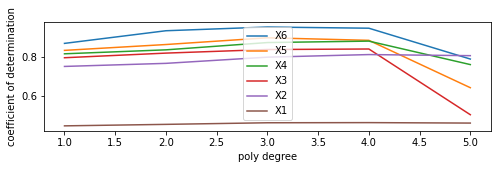

In [14]:
d.plot(xlabel='poly degree', ylabel='coefficient of determination', figsize=(8,2))

### Loss function
<!---Describe and explain (why?) your choice of loss function(s)*, e.g., logistic loss--->
Mean squared error (MSE) was used to evaluate estimation error because it's most straightforward for this simple model with many combinations of features and polynomial degrees.

### Validation
<!---Explain the process of model validation
- how did you split the data into training, validation and test sets. 
- What are the sizes of each set and why did you make such design choice
--->
At first, 30% of data is reserved for final evaluation, **testing**. Then, we split the rest of data into **training** and **validation** to find out hyperparameters(e.g. polynonial degrees). As seen below, taret value is not equally scattered. So we used [Stratifield KFold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to keep the same ratio of labels in each validation. The split group number is 5.

<AxesSubplot:>

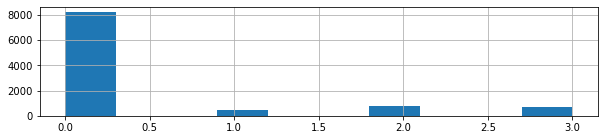

In [15]:
target = 'Room_Occupancy_Count'
#df[target].hist(figsize=(10,5))
df[target].hist(figsize=(10,2))

Here is a final accuracy comparison between X1 to X6 feeature set.

## Result
As seen below, if we use only X1:CO2, the prediction accuracy dropped drastically. Using 2 features, X2: CO2 and CO2_Slope with polynomial degree 4 may be reasonable choice. Using 2 features doesn't require a lot of initial investment of installing sensors in the field and also computation with polynomial degree 4 is smaller on TinyML sensor device. This basically depends on the requirements, how much accuracy is needed, how small TinyML device is and so on. In the future, more powerful TinyML device will be shipped, where we could investigate more complicated model on such devices.

In [16]:
d = {k: v for k, v in zip(['X6','X5','X4','X3','X2','X1'], accs)} 
d = pd.DataFrame({k: v for k, v in d.items()}, index=['accuracy'])
d

,X6,X5,X4,X3,X2,X1
accuracy,0.977624,0.925962,0.92333,0.9026,0.890424,0.737743


<AxesSubplot:>

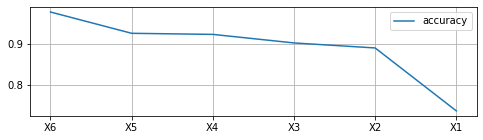

In [17]:
d.T.plot(figsize=(8,2), grid=True)

## Conclusion
We have examined how accurate to predict the number of people in a room with variety of sensor data combination, with the help of Machine Learning, more specifically, with polynomial regression. Only with CO2 emission and CO2 moving average, counting the number of people in a room achieved around 90% of accuracy. Altbhough this seems be useful, this really depends on the size of a room in use or number of sensors install in the place. This could be some reference to plan this occupancy counting in the real field. The further experiment in the real environment would be necessary. For example, with different number of sensors, with different location of sensor installation, with different TinyML sensor devices. 

## References
- dataset, https://www.kaggle.com/ananthr1/room-occupancy-estimation-data-set
- notebook, https://github.com/doyu/people_count_in_room/blob/main/people_count_in_room.ipynb